In [5]:
# Resnet Fine Tuning 

# import necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score
import time

import os
import sys
sys.path.append('../Utils')  # Add parent directory to sys.path
import utils as ut
import configs
import random

torch.manual_seed(42)   

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [6]:
# Create the class for fine tuning ResNet 

class ResNetFineTuner(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNetFineTuner, self).__init__()
        self.model = models.resnet18(pretrained=True)
        # Freeze all layers
        for param in self.model.parameters():
            param.requires_grad = False
        # Replace the final layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)
    
    def forward(self, x):
        return self.model(x)
    

    

In [ ]:
#  Define Train, Validation functions 

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=25, patience=5):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    epochs_no_improve = 0
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_acc_history.append(epoch_acc.item())
        train_loss_history.append(epoch_loss)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)

        val_acc_history.append(val_epoch_acc.item())
        val_loss_history.append(val_epoch_loss)

        print(f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')

        # Check for improvement
        if scheduler:
            scheduler.step(val_epoch_loss)

        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_model_wts = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print('Early stopping!')
                break
    print(f'Best val Acc: {best_acc:.4f}')
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history


def evaluate_model(model, test_loader):
    model.eval()
    all_preds = [] 
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


In [17]:
# Load and transform the data
# create data transforms

trabsform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


full_dataset = datasets.ImageFolder(configs.MULTIVIEW_TRAIN_DIR, transform=trabsform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(configs.MULTIVIEW_TEST_DIR, transform=trabsform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")
NUM_CLASSES = len(full_dataset.classes)
print(f"Number of classes: {NUM_CLASSES}")


Train size: 2228, Val size: 557, Test size: 670
Number of classes: 7


In [18]:
# Create the model, define the loss function and the optimizer 
model = ResNetFineTuner(num_classes=NUM_CLASSES)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9) 
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
# --- IGNORE ---



c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
# Train the model
model, train_acc_history, val_acc_history, train_loss_history, val_loss_history = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, patience=10
    
)
# Evaluate the model
y_true, y_pred = evaluate_model(model, test_loader)


Epoch 1/100
----------
Train Loss: 1.5600 Acc: 0.3941
Val Loss: 1.3085 Acc: 0.5171
Epoch 2/100
----------
Train Loss: 1.2631 Acc: 0.5274
Val Loss: 1.1677 Acc: 0.5835
Epoch 3/100
----------
Train Loss: 1.1536 Acc: 0.5759
Val Loss: 1.0988 Acc: 0.5853
Epoch 4/100
----------
Train Loss: 1.0894 Acc: 0.5996
Val Loss: 1.0783 Acc: 0.5978
Epoch 5/100
----------
Train Loss: 1.0520 Acc: 0.6073
Val Loss: 1.0319 Acc: 0.6248
Epoch 6/100
----------
Train Loss: 1.0208 Acc: 0.6180
Val Loss: 1.0136 Acc: 0.6338
Epoch 7/100
----------
Train Loss: 0.9871 Acc: 0.6252
Val Loss: 1.0133 Acc: 0.6373
Epoch 8/100
----------
Train Loss: 0.9582 Acc: 0.6382
Val Loss: 0.9763 Acc: 0.6445
Epoch 9/100
----------
Train Loss: 0.9376 Acc: 0.6526
Val Loss: 0.9845 Acc: 0.6373
Epoch 10/100
----------
Train Loss: 0.9335 Acc: 0.6607
Val Loss: 0.9552 Acc: 0.6517
Epoch 11/100
----------
Train Loss: 0.9119 Acc: 0.6513
Val Loss: 0.9383 Acc: 0.6463
Epoch 12/100
----------
Train Loss: 0.8989 Acc: 0.6728
Val Loss: 0.9453 Acc: 0.6661
E

In [20]:
# Calculate and print metrics
accuracy = accuracy_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Balanced Accuracy: {balanced_acc:.4f}")    
print(f"Test F1 Score: {f1:.4f}")
print(f"Test Precision: {precision:.4f}") 
# calulate model parameters 
params = ut.count_dl_parameters(model)
print(f"Model Parameters: {params}") 



Test Accuracy: 0.6403
Test Balanced Accuracy: 0.5553
Test F1 Score: 0.6285
Test Precision: 0.6365
Model Parameters: {'total_params': 11180103, 'trainable_params': 3591}


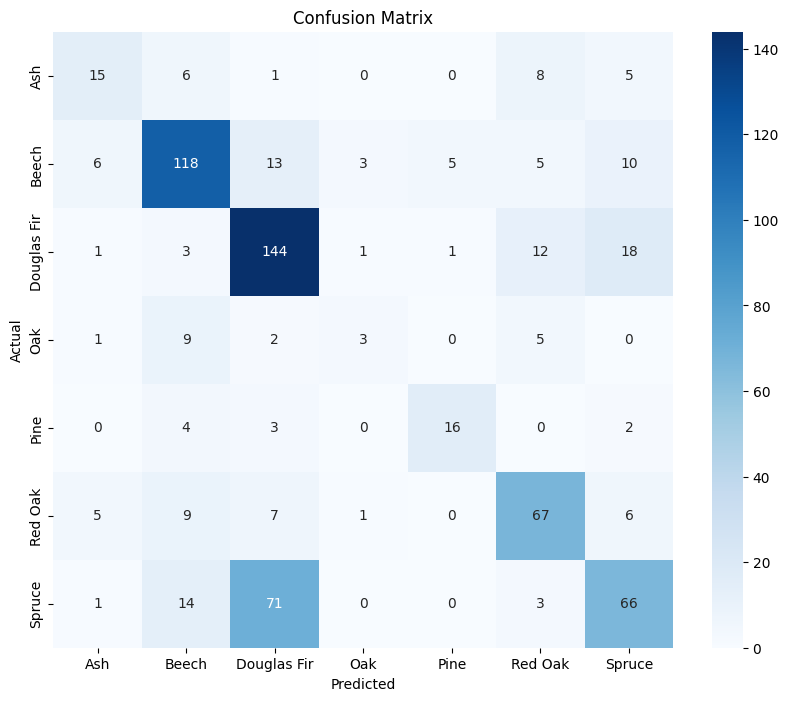

In [21]:
# Confucion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')   
plt.show()


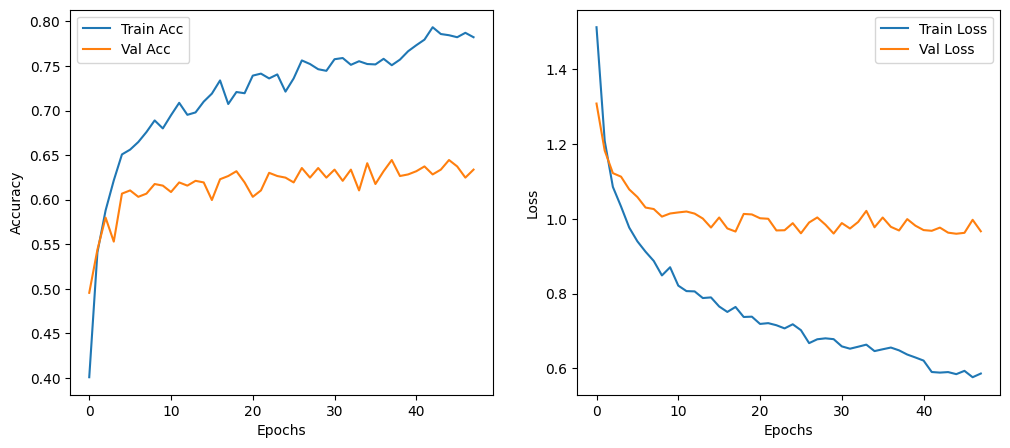

In [14]:
# plotting the Results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

